# FordGoBike System Data Exploratation


## Investigation Overview

In this project the features that effect the demand for bikes (i.e number of bike trips) and the duration of the trip are investigated. The main focus was on  the weekday, user type, and whether bike was shared for all trip.

## Dataset Overview

In this project, the trip data of FordGoBike from 2018 to 2019 will be explored. The data is available on 'https://s3.amazonaws.com/baywheels-data/index.html'. After wrangling the final cleaned dataset has 4370704 trip data with 18 features.

In [6]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
#packages for data gathering
import requests
from io import BytesIO
from zipfile import ZipFile
from bs4 import BeautifulSoup
import os
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

### Data Gathering

The data is available on 'https://s3.amazonaws.com/baywheels-data/index.html'. This data will be downloaded programmatically using the Selenium and Beautiful Soup packages and then read to a dataframe using requests library.

In [7]:
#Extracting url info from index.html 
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get('https://s3.amazonaws.com/baywheels-data/index.html')
try:
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'a')))
except TimeoutException:
    print('Page timed out after 10 secs.')
soup = BeautifulSoup(driver.page_source, 'html.parser')
tags=soup.find_all('a')
driver.quit()

[WDM] - Current google-chrome version is 83.0.4103
[WDM] - Get LATEST driver version for 83.0.4103
[WDM] - Driver [C:\Users\sushm\.wdm\drivers\chromedriver\win32\83.0.4103.39\chromedriver.exe] found in cache


 
Page timed out after 10 secs.


In [8]:
#Downloading from the url and unzipping the folder
for tag in tags[:-1]:
    url=tag.get('href')
    response=requests.get(url)
    zip_file = ZipFile(BytesIO(response.content))
    zip_file.extractall('ford-data')

In [9]:
path='ford-data'

Only the trip data in 2018 and 2019 will be explored as they have full year data whereas 2017 and 2020 have six month data

In [10]:
#Reading the each csv and storing a list of dataframes
data=[]
for file in os.listdir(path)[1:25]: #only data in 2018 and 2019
    data.append(pd.read_csv(path + '/' + file))

In [11]:
#concatenating dataframes
df=pd.concat(data,sort=False)
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method
0,75284,2018-01-31 22:52:35.2390,2018-02-01 19:47:19.8240,120.0,Mission Dolores Park,37.761420,-122.426435,285.0,Webster St at O'Farrell St,37.783521,-122.431158,2765,Subscriber,No,NaN
1,85422,2018-01-31 16:13:34.3510,2018-02-01 15:57:17.3100,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,2815,Customer,No,NaN
2,71576,2018-01-31 14:23:55.8890,2018-02-01 10:16:52.1160,304.0,Jackson St at 5th St,37.348759,-121.894798,296.0,5th St at Virginia St,37.325998,-121.877120,3039,Customer,No,NaN
3,61076,2018-01-31 14:53:23.5620,2018-02-01 07:51:20.5000,75.0,Market St at Franklin St,37.773793,-122.421239,47.0,4th St at Harrison St,37.780955,-122.399749,321,Customer,No,NaN
4,39966,2018-01-31 19:52:24.6670,2018-02-01 06:58:31.0530,74.0,Laguna St at Hayes St,37.776435,-122.426244,19.0,Post St at Kearny St,37.788975,-122.403452,617,Subscriber,No,NaN


### Data Cleaning

In [12]:
df_clean=df.copy()

In [13]:
df_clean.start_time=pd.to_datetime(df_clean.start_time)
df_clean.end_time=pd.to_datetime(df_clean.end_time)

In [14]:
values={'start_station_name':'Unknown', 'end_station_name':'Unknown',
        'start_station_id':-1,'end_station_id':-1}
df_clean.fillna(value=values,inplace=True)

In [15]:
df_clean['year']=df_clean.start_time.dt.year
df_clean['month']=df_clean.start_time.dt.month
df_clean['weekday']=df_clean.start_time.dt.weekday

## Distribution of Duration of trips

The distribution of duration of trips is right skewed with wide range of data. On log scale, the distribution is similar to normal distribution.The majority of trips have duration between 100-3000 seconds

In [16]:
df_clean=df_clean.query('duration_sec<10000') 

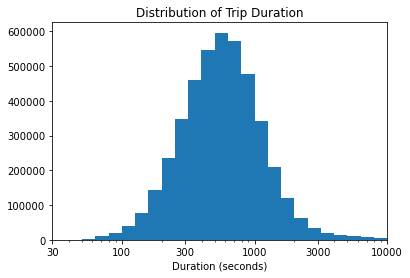

In [17]:
#plotting on log scale
bins = 10 ** np.arange(0, np.log10(df_clean.duration_sec.max())+0.1, 0.1)
plt.hist(data=df_clean,x='duration_sec', bins = bins)
plt.xscale('log')
tick_locs = [30, 100, 300, 1000, 3000,10000]
plt.xticks(tick_locs, tick_locs)
plt.xlim(30,10000)
plt.xlabel('Duration (seconds)')
plt.title('Distribution of Trip Duration');

## Distribution of trips by day of week

The number of trip on all weekdays i.e Monday to Friday is almost same with a slightly lower values on Monday and Friday . The number of trips on weekends is considerably lower than on weekdays. This can mean that majority of trips are work type trips rather than leisure trips

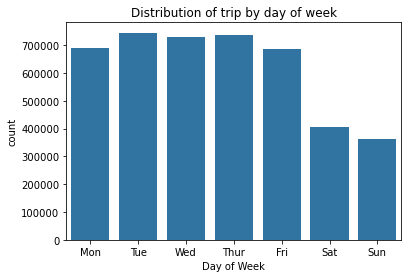

In [20]:
sb.countplot(data = df_clean, x = 'weekday', color = sb.color_palette()[0])
plt.xticks((0,1,2,3,4,5,6),('Mon','Tue','Wed','Thur','Fri','Sat','Sun'))
plt.title('Distribution of trip by day of week')
plt.xlabel('Day of Week');

## Distribution of trips by User Type

The number of trip made by subscribers is far greater than customers. This makes intutive sense as people who do take subscription have greater demand for the bikes. This also is in accordance to the previous observation that higher number of trips occur on weekday.

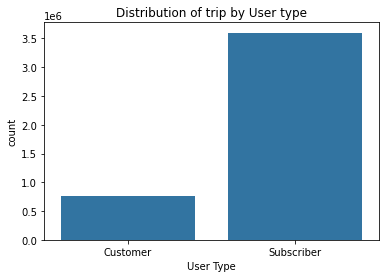

In [21]:
sb.countplot(data = df_clean, x = 'user_type', color = sb.color_palette()[0])
plt.title('Distribution of trip by User type')
plt.xlabel('User Type');

## Interaction between weekday, user type and duration

The mean duration of customer user type is higher than subscriber on each day of week.Moreover although the mean duration of subscribers remains almost constant, that for customers increases on weekend. This shows that customers tend to use bikes for longer trips while subscribers don't hesistate to use bike share for short trips too. It can also be said that customers tend to take longer leisure (weekends) trips than subscribers

In [23]:
df_clean['weekend']=df_clean.weekday.apply(lambda x:'Weekend' if x==5 or x==6
                                          else 'Weekday')

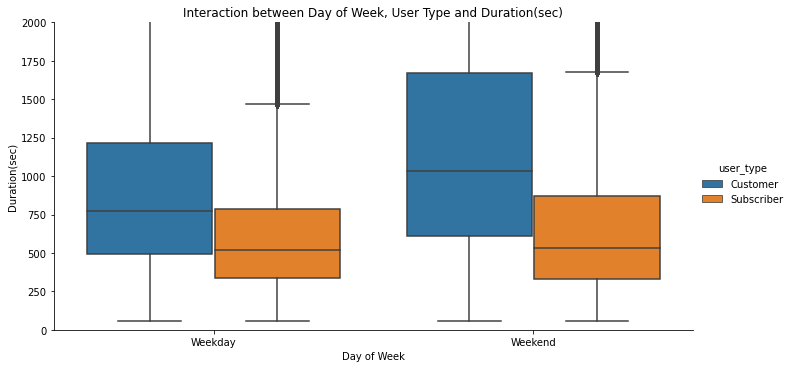

In [26]:
sb.catplot(x="weekend", y="duration_sec", hue="user_type",
               data=df_clean, kind="box",height=5, aspect=2)
plt.ylim((0,2000))
plt.title('Interaction between Day of Week, User Type and Duration(sec)')
plt.xlabel('Day of Week')
plt.ylabel('Duration(sec)');

## Interaction between weekday, bike_share_for_all_trip and duration
Trips without bike share for entire trip had greater duration than trips without bike share for entire trip on both weekdays and weekends. However the difference is more pronounced on weekends than on weekdays. This shows that longer duration on other modes during a trip is more likely in case of a leisure trip (trips on weekend) than work trips (trips on weekdays).

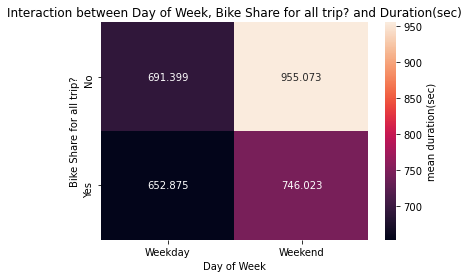

In [28]:
cat_means = df_clean.groupby(['weekend', 'bike_share_for_all_trip']).mean()['duration_sec'].reset_index()
cat_means = cat_means.pivot(index = 'bike_share_for_all_trip', 
                            columns = 'weekend',values = 'duration_sec')
sb.heatmap(cat_means, annot = True, fmt = '.3f',
           cbar_kws = {'label' : 'mean duration(sec)'})
plt.title('Interaction between Day of Week, Bike Share for all trip? and Duration(sec)')
plt.xlabel('Day of Week')
plt.ylabel('Bike Share for all trip?');